# Create interfaces

This section is meant for the more advanced user. In it we will discuss how you can create your own interface, i.e. wrapping your own code, so that you can use it with Nipype.

In this notebook we will show you:

1. Example of an already implemented interface
2. What are the main parts of a Nipype interface?
3. How to wrap a CommandLine interface?
4. How to wrap a Python interface?
5. How to wrap a MATLAB interface?

But before we can start, let's recap again the difference between interfaces and workflows.

## Interfaces vs. Workflows

Interfaces are the building blocks that solve well-defined tasks. We solve more complex tasks by combining interfaces with workflows:

<table style="width: 100%; font-size: 14px;">
  <thead>
    <th style="text-align:left">Interfaces</th>
    <th style="text-align:left">Workflows</th>
  </thead>
  <tbody>
    <tr>
      <td style="text-align:left">Wrap *unitary* tasks</td>
      <td style="text-align:left">Wrap *meta*-tasks
        <li style="text-align:left">implemented with nipype interfaces wrapped inside ``Node`` objects</li>
        <li style="text-align:left">subworkflows can also be added to a workflow without any wrapping</li>
      </td>
    </tr>
    <tr>
      <td style="text-align:left">Keep track of the inputs and outputs, and check their expected types</td>
      <td style="text-align:left">Do not have inputs/outputs, but expose them from the interfaces wrapped inside</td>
    </tr>
    <tr>
      <td style="text-align:left">Do not cache results (unless you use [interface caching](advanced_interfaces_caching.ipynb))</td>
      <td style="text-align:left">Cache results</td>
    </tr>
    <tr>
      <td style="text-align:left">Run by a nipype plugin</td>
      <td style="text-align:left">Run by a nipype plugin</td>
    </tr>
  </tbody>
</table>

# Example of an already implemented interface

For this notebook, we'll work on the following T1-weighted dataset located in ``/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz``:

In [1]:
from nilearn.plotting import plot_anat
%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


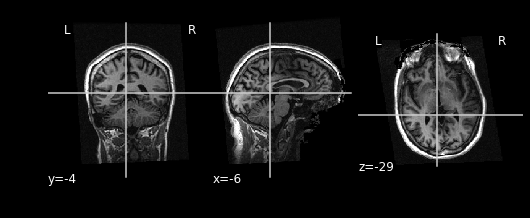

In [2]:
plot_anat('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz', dim=-1);

## Example of interface: FSL's `BET`

Nipype offers a series of Python interfaces to various external packages (e.g. FSL, SPM or FreeSurfer) even if they themselves are written in programming languages other than python. Such interfaces know what sort of options their corresponding tool has and how to execute it.

To illustrate why interfaces are so useful, let's have a look at the brain extraction algorithm [BET](http://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET) from FSL. Once in its original framework and once in the Nipype framework.

The tool can be run directly in a bash shell using the following command line:

In [3]:
%%bash
bet /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz \
    /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w_bet.nii.gz

... which yields the following:

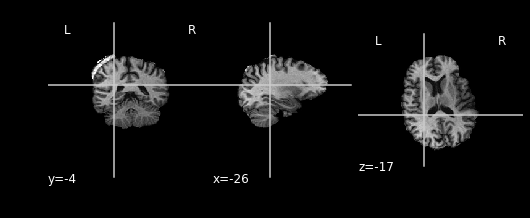

In [4]:
plot_anat('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w_bet.nii.gz', dim=-1);

Using nipype, the equivalent is a bit more verbose:
  - line 1: The first line imports the interface
  - line 2: Then, the interface is instantiated. We provide here the input file.
  - line 3: Finally, we run the interface
  - line 4: The output file name can be automatically handled by nipype, and we will use that feature here

In [5]:
from nipype.interfaces.fsl import BET
skullstrip = BET(in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
res = skullstrip.run()
print(res.outputs.out_file)

/home/neuro/workshop/local/notebooks/sub-01_ses-test_T1w_brain.nii.gz


Now we can verify that the result is exactly the same as before. Please note that, since we are using a Python environment, we use the result of the execution to point our ``plot_anat`` function to the output image of running BET:

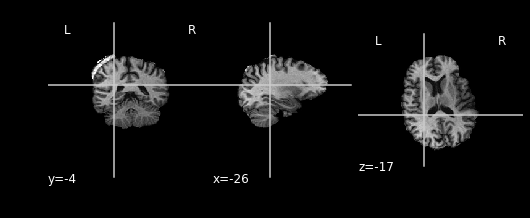

In [6]:
plot_anat(res.outputs.out_file, dim=-1);

# What are the main parts of a Nipype interface?

Nipype is designed to ease writing interfaces for new software. Nipype interfaces are designed with three elements that are intuitive:
  - A specification of inputs (or the ``InputSpec``)
  - A specification of outputs (or the ``OutputSpec``)
  - An interface *core* which implements the ``run()`` method we've seen before for BET, and which puts together inputs and outputs.

# The ``CommandLine`` interface

## A quick example

The easiest and quickest way to run any command line is the ``CommandLine`` interface, which has a very simple specification of inputs ready to use:

In [7]:
from nipype.interfaces.base import CommandLine
CommandLine.help()

Implements functionality to interact with command line programs
class must be instantiated with a command argument

Parameters
----------

command : string
    define base immutable `command` you wish to run

args : string, optional
    optional arguments passed to base `command`


Examples
--------
>>> import pprint
>>> from nipype.interfaces.base import CommandLine
>>> cli = CommandLine(command='ls', environ={'DISPLAY': ':1'})
>>> cli.inputs.args = '-al'
>>> cli.cmdline
'ls -al'

# Use get_traitsfree() to check all inputs set
>>> pprint.pprint(cli.inputs.get_traitsfree())  # doctest:
{'args': '-al',
 'environ': {'DISPLAY': ':1'}}

>>> cli.inputs.get_hashval()[0][0]
('args', '-al')
>>> cli.inputs.get_hashval()[1]
'11c37f97649cd61627f4afe5136af8c0'

Inputs::

        [Optional]
        args: (a unicode string)
                Additional parameters to the command
                argument: ``%s``
        environ: (a dictionary with keys which are a bytes or None or a value
              

As a quick example, let's wrap bash's ``ls`` with Nipype:

In [8]:
nipype_ls = CommandLine('ls', args='-lh', terminal_output='allatonce')

Now, we have a Python object ``nipype_ls`` that is a runnable nipype interface. After execution, Nipype interface returns a result object. We can retrieve the output of our ``ls`` invocation from the ``result.runtime`` property:

In [9]:
result = nipype_ls.run()
print(result.runtime.stdout)

total 31M
-rw-r--r--  1 neuro users  52K Oct 22 05:51 advanced_create_interfaces.ipynb
-rw-r--r--  1 neuro users  14K Oct 21 05:58 basic_data_input_bids.ipynb
-rw-r--r--  1 neuro users  28K Oct 22 01:33 basic_data_input.ipynb
-rw-r--r--  1 neuro users  19K Oct 22 01:33 basic_data_output.ipynb
-rw-r--r--  1 neuro users 4.1K Oct 22 01:42 basic_debug.ipynb
-rw-r--r--  1 neuro users  21K Oct 22 01:33 basic_error_and_crashes.ipynb
-rw-r--r--  1 neuro users  17K Oct 21 05:58 basic_execution_configuration.ipynb
-rw-r--r--  1 neuro users 9.1K Oct 22 01:53 basic_function_interface.ipynb
-rw-r--r--  1 neuro users  11K Oct 22 01:32 basic_graph_visualization.ipynb
-rw-r--r--  1 neuro users 9.2K Oct 21 05:58 basic_import_workflows.ipynb
-rw-r--r--  1 neuro users  25K Oct 22 00:49 basic_interfaces.ipynb
-rw-r--r--  1 neuro users  12K Oct 22 04:30 basic_iteration.ipynb
-rw-r--r--  1 neuro users  19K Oct 21 05:58 basic_joinnodes.ipynb
-rw-r--r--  1 neuro users  13K Oct 21 05:58 basic_mapnodes.ipynb
-r

## Create your own `CommandLine` interface

Let's create a Nipype Interface for a very simple tool called ``antsTransformInfo`` from the [ANTs](http://stnava.github.io/ANTs/) package. This tool is so simple it does not even have a usage description for bash. Using it with a file, gives us the following result: 

In [10]:
%%bash
antsTransformInfo /home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm

Transform file: /home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm
AffineTransform (0x55e84aa189d0)
  RTTI typeinfo:   itk::AffineTransform<double, 3u>
  Reference Count: 3
  Modified Time: 660
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    1.0201 -0.00984231 0.00283729 
    -0.245557 0.916396 0.324585 
    -0.0198016 -0.00296066 0.988634 
  Offset: [2.00569, -15.15, -1.26341]
  Center: [-3.37801, 17.4338, 8.46811]
  Translation: [1.79024, -13.0295, -1.34439]
  Inverse: 
    0.982713 0.0105343 -0.00627888 
    0.256084 1.09282 -0.359526 
    0.0204499 0.00348366 1.01029 
  Singular: 0



### So let's plan our implementation:

  1. The command line name is ``antsTransformInfo``.
  2. It only accepts one text file (containing an ITK transform file) as input, and it is a positional argument.
  3. It prints out the properties of the transform in the input file. For the purpose of this notebook, we are only interested in extracting the translation values.
  
For the first item of this roadmap, we will just need to derive a new Python class from the ``nipype.interfaces.base.CommandLine`` base. To indicate the appropriate command line, we set the member ``_cmd``:

In [11]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'

This is enough to have a nipype compatible interface for this tool:

In [12]:
TransformInfo.help()

Wraps the executable command ``antsTransformInfo``.

Inputs::

        [Optional]
        args: (a unicode string)
                Additional parameters to the command
                argument: ``%s``
        environ: (a dictionary with keys which are a bytes or None or a value
                  of class 'str' and with values which are a bytes or None or a
                  value of class 'str', nipype default value: {})
                Environment variables

Outputs::

        None



### Specifying the inputs

However, the ``args`` argument is too generic and does not deviate much from just running it in bash, or directly using ``subprocess.Popen``. Let's define the inputs specification for the interface, extending the ``nipype.interfaces.base.CommandLineInputSpec`` class.

The inputs are implemented using the Enthought traits package. For now, we'll use the ``File`` trait extension of nipype:

In [13]:
from nipype.interfaces.base import CommandLineInputSpec, File

class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s',
                   position=0, desc='the input transform file')

Some settings are done for this ``File`` object:
- ``exists=True`` indicates Nipype that the file must exist when it is set
- ``mandatory=True`` checks that this input was set before running because the program would crash otherwise
- ``argstr='%s'`` indicates how this input parameter should be formatted
- ``position=0`` indicates  that this is the first positional argument

We can now decorate our ``TransformInfo`` core class with its input, by setting the ``input_spec`` member:

In [14]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec

Our interface now has one mandatory input, and inherits some optional inputs from the ``CommandLineInputSpec``:

In [15]:
TransformInfo.help()

Wraps the executable command ``antsTransformInfo``.

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                the input transform file
                argument: ``%s``, position: 0

        [Optional]
        args: (a unicode string)
                Additional parameters to the command
                argument: ``%s``
        environ: (a dictionary with keys which are a bytes or None or a value
                  of class 'str' and with values which are a bytes or None or a
                  value of class 'str', nipype default value: {})
                Environment variables

Outputs::

        None



One interesting feature of the Nipype interface is that the underlying command line can be checked using the object property ``cmdline``. The command line can only be built when the mandatory inputs are set, so let's instantiate our new Interface for the first time, and check the underlying command line:

In [16]:
my_info_interface = TransformInfo(in_file='/home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm')
print(my_info_interface.cmdline)

antsTransformInfo /home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm


Nipype will make sure that the parameters fulfill their prescribed attributes. For instance, ``in_file`` is mandatory. An error is issued if we build the command line or try to run this interface without it:

In [17]:
try:
    TransformInfo().cmdline

except(ValueError) as err:
    print('It crashed with...')
    print("ValueError:", err)
else:
    raise

It crashed with...
ValueError: TransformInfo requires a value for input 'in_file'. For a list of required inputs, see TransformInfo.help()


It will also complain if we try to set a non-existent file:

In [18]:
try:
    my_info_interface.inputs.in_file = 'idontexist.tfm'

except(Exception) as err:
    print('It crashed with...')
    print("TraitError:", err)
else:
    raise

It crashed with...
TraitError: The 'in_file' trait of a TransformInfoInputSpec instance must be a pathlike object or string representing an existing file, but a value of 'idontexist.tfm' <class 'str'> was specified.


### Specifying the outputs
The outputs are defined in a similar way. Let's define a custom output for our interface which is a list of three float element. The output traits are derived from a simpler base class called ``TraitedSpec``. We also import the two data representations we need ``List`` and ``Float``:

In [19]:
from nipype.interfaces.base import TraitedSpec, traits

class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')
    
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec

And now, our new output is in place:

In [20]:
TransformInfo.help()

Wraps the executable command ``antsTransformInfo``.

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                the input transform file
                argument: ``%s``, position: 0

        [Optional]
        args: (a unicode string)
                Additional parameters to the command
                argument: ``%s``
        environ: (a dictionary with keys which are a bytes or None or a value
                  of class 'str' and with values which are a bytes or None or a
                  value of class 'str', nipype default value: {})
                Environment variables

Outputs::

        translation: (a list of items which are a float)
                the translation component of the input transform



### We are almost there - final needs
If we run the interface, we'll be able to see that this tool only writes some text to the standard output, but we just want to extract the ``Translation`` field and generate a Python object from it.

In [21]:
my_info_interface = TransformInfo(in_file='/home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm',
                                  terminal_output='allatonce')
result = my_info_interface.run()

In [22]:
print(result.runtime.stdout)

Transform file: /home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm
AffineTransform (0x55d927cb79d0)
  RTTI typeinfo:   itk::AffineTransform<double, 3u>
  Reference Count: 3
  Modified Time: 660
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    1.0201 -0.00984231 0.00283729 
    -0.245557 0.916396 0.324585 
    -0.0198016 -0.00296066 0.988634 
  Offset: [2.00569, -15.15, -1.26341]
  Center: [-3.37801, 17.4338, 8.46811]
  Translation: [1.79024, -13.0295, -1.34439]
  Inverse: 
    0.982713 0.0105343 -0.00627888 
    0.256084 1.09282 -0.359526 
    0.0204499 0.00348366 1.01029 
  Singular: 0



We need to complete the functionality of the ``run()`` member of our interface to parse the standard output. This is done extending its ``_run_interface()`` member.

When we define outputs, generally they need to be explicitly wired in the ``_list_outputs()`` member of the core class. Let's see how we can *complete* those:

In [23]:
class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}

Let's run this interface (we set ``terminal_output='allatonce'`` to reduce the length of this manual, default would otherwise be `'stream'`):

In [24]:
my_info_interface = TransformInfo(in_file='/home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm',
                                  terminal_output='allatonce')
result = my_info_interface.run()

Now we can retrieve our outcome of interest as an output:

In [25]:
result.outputs.translation

[1.79024, -13.0295, -1.34439]

### Summary of a `CommandLine` interface

Now putting it all togehter, it looks as follows:

In [26]:
from nipype.interfaces.base import (CommandLine, CommandLineInputSpec,
                                    TraitedSpec, traits, File)

class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0,
                   desc='the input transform file')

class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')

class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}

In [27]:
my_info_interface = TransformInfo(in_file='/home/neuro/nipype_tutorial/notebooks/scripts/transform.tfm',
                                  terminal_output='allatonce')
result = my_info_interface.run()
result.outputs.translation

[1.79024, -13.0295, -1.34439]

### Wrapping up - fast use case for simple `CommandLine` wrapper

For more standard neuroimaging software, generally we will just have to specify simple flags, i.e. input and output images and some additional parameters. If that is the case, then there is no need to extend the ``run()`` method.

Let's look at a quick, partial, implementation of FSL's BET:

In [28]:
from nipype.interfaces.base import CommandLineInputSpec, File, TraitedSpec

class CustomBETInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input image')
    mask = traits.Bool(mandatory=False, argstr='-m', position=2, desc='create binary mask image')

    # Do not set exists=True for output files!
    out_file = File(mandatory=True, argstr='%s', position=1, desc='the output image')
    
class CustomBETOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    mask_file = File(desc="path/name of binary brain mask (if generated)")
    
class CustomBET(CommandLine):
    _cmd = 'bet'
    input_spec = CustomBETInputSpec
    output_spec = CustomBETOutputSpec
    
    def _list_outputs(self):

        # Get the attribute saved during _run_interface
        return {'out_file': self.inputs.out_file,
                'mask_file': self.inputs.out_file.replace('brain', 'brain_mask')}

In [29]:
my_custom_bet = CustomBET()
my_custom_bet.inputs.in_file = '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'
my_custom_bet.inputs.out_file = 'sub-01_T1w_brain.nii.gz'
my_custom_bet.inputs.mask = True
result = my_custom_bet.run()

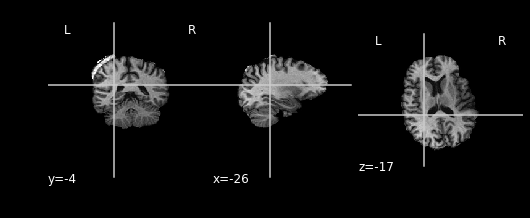

In [30]:
plot_anat(result.outputs.out_file, dim=-1);

# Create your own `Python` interface

`CommandLine` interface is great, but my tool is already in Python - can I wrap it natively?

Sure. Let's solve the following problem: Let's say we have a Python function that takes an input image and a list of three translations (x, y, z) in mm, and then writes a resampled image after the translation has been applied:

In [31]:
def translate_image(img, translation, out_file):

    import nibabel as nb
    import numpy as np
    from scipy.ndimage.interpolation import affine_transform
    
    # Load the data
    nii = nb.load(img)
    data = nii.get_data()
    
    # Create the transformation matrix
    matrix = np.eye(3)
    trans = (np.array(translation) / nii.header.get_zooms()[:3]) * np.array([1.0, -1.0, -1.0])
    
    # Apply the transformation matrix
    newdata = affine_transform(data, matrix=matrix, offset=trans)
    
    # Save the new data in a new NIfTI image
    nb.Nifti1Image(newdata, nii.affine, nii.header).to_filename(out_file)
    
    print('Translated file now is here: %s' % out_file)

Let's see how this function operates:

In [32]:
orig_image = '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'
translation = [20.0, -20.0, -20.0]
translated_image = 'translated.nii.gz'

# Let's run the translate_image function on our inputs
translate_image(orig_image,
                translation,
                translated_image)

Translated file now is here: translated.nii.gz


Now that the function was executed, let's plot the original and the translated image.

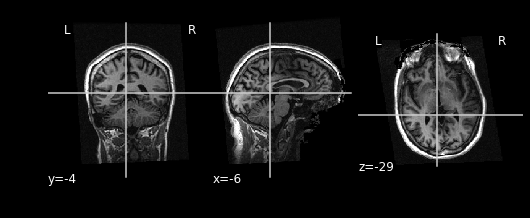

In [33]:
plot_anat(orig_image, dim=-1);

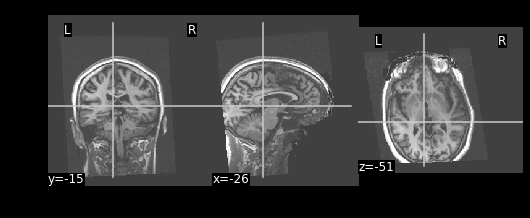

In [34]:
plot_anat('translated.nii.gz', dim=-1);

Perfect, we see that the translation was applied.

## Quick approach - ``Function`` interface

Don't reinvent the wheel if it's not necessary. If like in this case, we have a well-defined function we want to run with Nipype, it is fairly easy to solve it with the ``Function`` interface:

In [35]:
from nipype.interfaces.utility import Function

my_python_interface = Function(
    input_names=['img', 'translation', 'out_file'],
    output_names=['out_file'],
    function=translate_image
)

The arguments of ``translate_image`` should ideally be listed in the same order and with the same names as in the signature of the function. The same should be the case for the outputs. Finally, the ``Function`` interface takes a ``function`` input that is pointed to your python code.

***Note***: The inputs and outputs do not pass any kind of conformity checking: the function node will take any kind of data type for their inputs and outputs.

There are some other limitations to the ``Function`` interface when used inside workflows. Additionally, the function must be totally self-contained, since it will run with no global context. In practice, it means that **all the imported modules and variables must be defined within the context of the function**.

For more, check out the [Function Node](basic_function_nodes.ipynb) notebook.

Back to our `Function` interface. You can run it as any other interface object of Nipype:

In [36]:
# Set inputs
my_python_interface.inputs.img = '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'
my_python_interface.inputs.translation = [-35.0, 35.0, 35.0]
my_python_interface.inputs.out_file = 'translated_functioninterface.nii.gz'

In [37]:
# Run the interface
result = my_python_interface.run()

Translated file now is here: translated_functioninterface.nii.gz


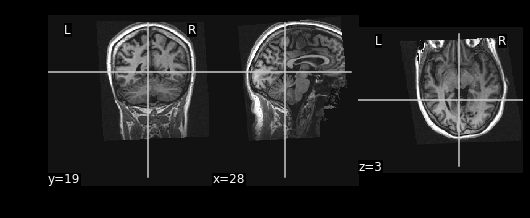

In [38]:
# Plot the result
plot_anat('translated_functioninterface.nii.gz', dim=-1);

## Complete approach - pure `Python` interface

Now, we face the problem of interfacing something different from a command line. Therefore, the ``CommandLine`` base class will not help us here. The specification of the inputs and outputs, though, will work the same way.

Let's start from that point on. Our Python function takes in three inputs: (1) the input image, (2) the translation and (3) an output image.

The specification of inputs and outputs must be familiar to you at this point. Please note that now, input specification is derived from ``BaseInterfaceInputSpec``, which is a bit thinner than ``CommandLineInputSpec``. The output specification can be derived from ``TraitedSpec`` as before:

In [39]:
from nipype.interfaces.base import BaseInterfaceInputSpec, File, TraitedSpec

class TranslateImageInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True, desc='the input image')
    out_file = File(mandatory=True, desc='the output image') # Do not set exists=True !!
    translation = traits.List([50.0, 0.0, 0.0], traits.Float, usedefault=True,
                              desc='the translation component of the input transform')
    
class TranslateImageOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')

Similarily to the change of base class for the input specification, the core of our new interface will derive from ``BaseInterface`` instead of ``CommandLineInterface``:

In [40]:
from nipype.interfaces.base import BaseInterface

class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec

At this point, we have defined a pure python interface but it is unable to do anything because we didn't implement a ``_run_interface()`` method yet.

In [41]:
TranslateImage.help()

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                the input image
        out_file: (a pathlike object or string representing a file)
                the output image

        [Optional]
        translation: (a list of items which are a float, nipype default
                  value: [50.0, 0.0, 0.0])
                the translation component of the input transform

Outputs::

        out_file: (a pathlike object or string representing a file)
                the output image



What happens if we try to run such an interface without specifying the `_run_interface()` function?

In [42]:
will_fail_at_run = TranslateImage(
    in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz',
    out_file='translated.nii.gz')

In [43]:
try:
    result = will_fail_at_run.run()

except(NotImplementedError) as err:
    print('It crashed with...')
    print("NotImplementedError:", err)
else:
    raise

It crashed with...
NotImplementedError: 


So, let's implement the missing part. As we would imagine, this needs to be very similar to what we did before with the ``TransformInfo`` interface:

In [44]:
class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec
    
    def _run_interface(self, runtime):
        
        # Call our python code here:
        translate_image(
            self.inputs.in_file,
            self.inputs.translation,
            self.inputs.out_file
        )
        
        # And we are done
        return runtime

If we run it know, our interface will get further:

In [45]:
half_works = TranslateImage(
    in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz',
    out_file='translated_nipype.nii.gz')

In [46]:
try:
    result = half_works.run()

except(NotImplementedError) as err:
    print('It crashed with...')
    print("NotImplementedError:", err)
else:
    raise

Translated file now is here: translated_nipype.nii.gz
It crashed with...
NotImplementedError: 


... but still, it crashes becasue we haven't specified any ``_list_outputs()`` method. I.e. our python function is called, but the interface crashes when the execution arrives to retrieving the outputs.

Let's fix that:

In [47]:
from nipype.interfaces.base import BaseInterfaceInputSpec, BaseInterface, File, TraitedSpec

class TranslateImageInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True, desc='the input image')
    out_file = File(mandatory=True, desc='the output image') # Do not set exists=True !!
    translation = traits.List([50.0, 0.0, 0.0], traits.Float, usedefault=True,
                              desc='the translation component of the input transform')
    
class TranslateImageOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')

class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        translate_image(
            self.inputs.in_file,
            self.inputs.translation,
            self.inputs.out_file
        )
        # And we are done
        return runtime

    def _list_outputs(self):
        return {'out_file': self.inputs.out_file}

Now, we have everything together. So let's run it and visualize the output file.

In [48]:
this_works = TranslateImage(
    in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz',
    out_file='translated_nipype.nii.gz')

result = this_works.run()

Translated file now is here: translated_nipype.nii.gz


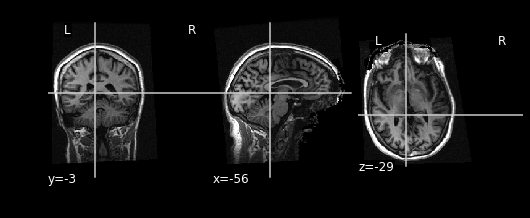

In [49]:
plot_anat(result.outputs.out_file, dim=-1);

# Create your own `MATLAB` interface

Last but not least, let's take a look at how we would create a `MATLAB` interface. For this purpose, let's say we want to run some matlab code that counts the number of voxels in an MRI image with intensity larger than zero. Such a value could give us an estimation of the brain volume (in voxels) of a skull-stripped image.

In `MATLAB`, our code looks as follows:

  ```
  load input_image.mat;
  total = sum(data(:) > 0)
  ```
  
The following example uses ``scipy.io.savemat`` to convert the input image to `MATLAB` format. Once the file is loaded we can quickly extract the estimated total volume.

***Note:*** For the purpose of this example, we will be using the freely available `MATLAB` alternative `Octave`. But the implementation of a `MATLAB` interface will be identical.

## Preparation

As before, we need to specify an `InputSpec` and an `OutputSpec` class. The input class will expect a `file` as an input and the `script` containing the code that we would like to run, and the output class will give us back the total `volume`.

In the context of a `MATLAB` interface, this is implemented as follows:

In [50]:
from nipype.interfaces.base import (CommandLine, traits, TraitedSpec,
                                    BaseInterface, BaseInterfaceInputSpec, File)

class BrainVolumeMATLABInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True)
    script_file = File(exists=True, mandatory=True)
    
class BrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')

class BrainVolumeMATLAB(BaseInterface):
    input_spec = BrainVolumeMATLABInputSpec
    output_spec = BrainVolumeMATLABOutputSpec

## Step by step implementation

Now, we have to specify what should happen, once the interface is run. As we said earlier, we want to:

1. load the image data and save it in a mat file
2. load the script
3. replace the put the relevant information into the script
4. run the script
5. extract the results

This all can be implemented with the following code:

In [51]:
# Specify the interface inputs
in_file = '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'
script_file = '/home/neuro/nipype_tutorial/notebooks/scripts/brainvolume.m'

In [52]:
!cat scripts/brainvolume.m

cat: scripts/brainvolume.m: No such file or directory


In [53]:
import re
import nibabel as nb
from scipy.io import savemat

# 1. save the image in matlab format as tmp_image.mat
tmp_image = 'tmp_image'
data = nb.load(in_file).get_data()
savemat(tmp_image, {b'data': data}, do_compression=False)

In [54]:
# 2. load script
with open(script_file) as script_file:
    script_content = script_file.read()

In [55]:
# 3. replace the input_image.mat file with the actual input of this interface
with open('newscript.m', 'w') as script_file:
    script_file.write(script_content.replace('input_image.mat', 'tmp_image.mat'))

In [56]:
# 4. run the matlab script
mlab = CommandLine('octave', args='newscript.m', terminal_output='stream')
result = mlab.run()

191022-05:53:23,805 nipype.interface INFO:
	 stderr 2019-10-22T05:53:23.805768:octave: X11 DISPLAY environment variable not set
191022-05:53:23,807 nipype.interface INFO:
	 stderr 2019-10-22T05:53:23.807635:octave: disabling GUI features
191022-05:53:24,340 nipype.interface INFO:
	 stdout 2019-10-22T05:53:24.340349:total =  5308353


In [57]:
# 5. extract the volume estimation from the output
expr_tra = re.compile('total\ =\s+(?P<total>[0-9]+)')
volume = int(expr_tra.search(result.runtime.stdout).groupdict()['total'])
print(volume)

5308353


## Putting it all together

Now we just need to put this all together in the `_run_interface()` method and add a `_list_outputs()` function:

In [58]:
from nipype.interfaces.base import (CommandLine, traits, TraitedSpec,
                                    BaseInterface, BaseInterfaceInputSpec, File)
import re
import nibabel as nb
from scipy.io import savemat

class BrainVolumeMATLABInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True)
    script_file = File(exists=True, mandatory=True)
    
class BrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')

class BrainVolumeMATLAB(BaseInterface):
    input_spec = BrainVolumeMATLABInputSpec
    output_spec = BrainVolumeMATLABOutputSpec

    def _run_interface(self, runtime): 
        # Save the image in matlab format as tmp_image.mat
        tmp_image = 'tmp_image'
        data = nb.load(self.inputs.in_file).get_data()
        savemat(tmp_image, {b'data': data}, do_compression=False)
        
        # Load script
        with open(self.inputs.script_file) as script_file:
            script_content = script_file.read()
        
        # Replace the input_image.mat file for the actual input of this interface
        with open('newscript.m', 'w') as script_file:
            script_file.write(script_content.replace('input_image.mat', 'tmp_image.mat'))

        # Run a matlab command
        mlab = CommandLine('octave', args='newscript.m', terminal_output='stream')
        result = mlab.run()
        
        # Parse matlab output and save to '_volume' attribute so it can be accessed
        # in '_list_outputs'
        self._volume = int(re.search(r'total\ =\s+(?P<total>[0-9]+)',
                                     result.runtime.stdout).groupdict()['total'])

        return result.runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['volume'] = getattr(self, '_volume')
        return outputs

Let's test it out:

In [59]:
matlab = BrainVolumeMATLAB(in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz',
                           script_file='/home/neuro/nipype_tutorial/notebooks/scripts/brainvolume.m')
result = matlab.run()

191022-05:53:24,923 nipype.interface INFO:
	 stderr 2019-10-22T05:53:24.923711:octave: X11 DISPLAY environment variable not set
191022-05:53:24,925 nipype.interface INFO:
	 stderr 2019-10-22T05:53:24.925166:octave: disabling GUI features
191022-05:53:25,216 nipype.interface INFO:
	 stdout 2019-10-22T05:53:25.216631:total =  5308353


In [60]:
print(result.outputs)


volume = 5308353



## Alternative implementation

Alternatively, we can write the interface as an extension of the `MatlabCommand` interface and/or use builtin Matlab
methods for accessing NIfTI files. Which methods to use mainly depends on your personal preferences :)

In [63]:
import re  # Regular-expressions module
from nipype.interfaces.base import traits, TraitedSpec
from nipype.interfaces.matlab import MatlabCommand, MatlabInputSpec


class AlternativeBrainVolumeMATLABInputSpec(MatlabInputSpec):
    in_file = File(exists=True, mandatory=True)

    
class AlternativeBrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')
    matlab_output = traits.Str()


class AlternativeBrainVolumeMATLAB(MatlabCommand):
    input_spec = AlternativeBrainVolumeMATLABInputSpec
    output_spec = AlternativeBrainVolumeMATLABOutputSpec

    def _generate_script(self):
        """This is where you implement your script"""
        return """
            data = niftiread('{in_file}');
            total = sum(data(:) > 0)
        """.format(in_file=self.inputs.in_file)

    def run(self, **inputs):
        # Inject our script into the Matlab input interface
        self.inputs.script = self._generate_script()
        
        # Run the 'run' method in the MatlabCommand base class
        results = super(MatlabCommand, self).run(**inputs)

        # Attach stdout to outputs to access matlab results
        results.outputs.matlab_output = results.runtime.stdout

        return results

    def _list_outputs(self):
        # Get outputs dictionary
        outputs = self._outputs().get()

        # Use a regular expression to extract out the volume from the matlab output
        outputs['volume'] = int(re.search(r'total\ =\s+(?P<total>[0-9]+)',
                                          outputs['matlab_output']).groupdict()['total'])

        return outputs

Let's test it out:

In [64]:
matlab = AlternativeBrainVolumeMATLAB(in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
result = matlab.run()

RuntimeError: Command:
matlab -nodesktop -nosplash -singleCompThread -r "addpath('/home/neuro/workshop/local/notebooks');pyscript;exit"
Standard output:
MATLAB is selecting SOFTWARE OPENGL rendering.
---------------------------------------------------------------------------
Warning: Cannot locate Java Runtime Environment (JRE) . . .
 
         1. Either a correct JRE was not available for redistribution when
            this release was shipped, in which case you should refer to the
            Release Notes for additional information about how to get it.
 
         2. Or you have tried to use the MATLAB_JAVA environment variable
            to specify an alternate JRE, but MATLAB cannot find it.  Please
            run 'matlab -n' to determine what value you are using for
            MATLAB_JAVA and fix accordingly.
---------------------------------------------------------------------------

    matlab: No MATLAB bin directory for this machine architecture.

           ARCH = glnxa64

Standard error:

Return code: 1

In [ ]:
print(result.outputs)

We see in the examples above that everything works fine. But now, let's say that we want to save the total brain volume to a file and give the location of this file back as an output. How would you do that?

## Exercise

Modify the `BrainVolumeMATLAB` interface so that it has one more **output** called ``out_file``, that points to a text file where we write the volume in voxels. The name of the ``out_file`` can be hard coded to ``volume.txt``.

In [ ]:
# Write your solution here

In [ ]:
from nipype.interfaces.base import (CommandLine, traits, TraitedSpec,
                                    BaseInterface, BaseInterfaceInputSpec, File)
import os
import re
import nibabel as nb
from scipy.io import savemat

class BrainVolumeMATLABInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True)
    script_file = File(exists=True, mandatory=True)
    
class BrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')
    out_file = File(desc='output file containing total brain volume')  # This line was added

class BrainVolumeMATLAB(BaseInterface):
    input_spec = BrainVolumeMATLABInputSpec
    output_spec = BrainVolumeMATLABOutputSpec

    def _run_interface(self, runtime): 
        # Save the image in matlab format as tmp_image.mat
        tmp_image = 'tmp_image'
        data = nb.load(self.inputs.in_file).get_data()
        savemat(tmp_image, {b'data': data}, do_compression=False)
        
        # Load script
        with open(self.inputs.script_file) as script_file:
            script_content = script_file.read()
        
        # Replace the input_image.mat file for the actual input of this interface
        with open('newscript.m', 'w') as script_file:
            script_file.write(script_content.replace('input_image.mat', 'tmp_image.mat'))

        # Run a matlab command
        mlab = CommandLine('octave', args='newscript.m', terminal_output='stream')
        result = mlab.run()
        
        expr_tra = re.compile('total\ =\s+(?P<total>[0-9]+)')
        volume = int(expr_tra.search(result.runtime.stdout).groupdict()['total'])
        setattr(self, '_result', volume)
        
        # Write total brain volume into a file
        out_fname = os.path.abspath('volume.txt')
        setattr(self, '_out_file', out_fname)
        with open('volume.txt', 'w') as out_file:
            out_file.write('%d' %volume)
        
        return result.runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['volume'] = getattr(self, '_result')
        outputs['out_file'] = getattr(self, '_out_file')
        return outputs

Now, let's test if it works.

In [ ]:
matlab = BrainVolumeMATLAB(in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz',
                           script_file='/home/neuro/nipype_tutorial/notebooks/scripts/brainvolume.m')
result = matlab.run()

No errors, perfect. Did we get the right file?

In [ ]:
print(result.outputs.out_file)

And what about the content of this file?

In [ ]:
!cat volume.txt